$Yμ∼N(μ,σ2)=α+β1X1+β2X2$


We set priors for parameters.
$α∼N(0,100) \\
βi∼N(0,100) \\
σ∼|N(0,1)|$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')

# set seed
np.random.seed(123)

# true values 
alpha, sigma = 1, 1
beta = [1, 2.5]

size = 100


X1 = np.random.randn(size)
X2 = np.random.randn(size)*0.2
# tuple is immutable object with ()
# list is mutable obj with []
# dict is {}, key chain value. Hash map maybe.

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [2]:
print(X1[:6],X2[:6])

[-1.0856306   0.99734545  0.2829785  -1.50629471 -0.57860025  1.65143654] [ 0.12841094 -0.39557759  0.14245293  0.51966079 -0.0049252   0.00682843]


In [6]:
print(Y[:6])

[0.93870686 0.41029615 3.83981292 1.48115418 0.40277951 2.4618453 ]


Text(0.5, 0, 'X2')

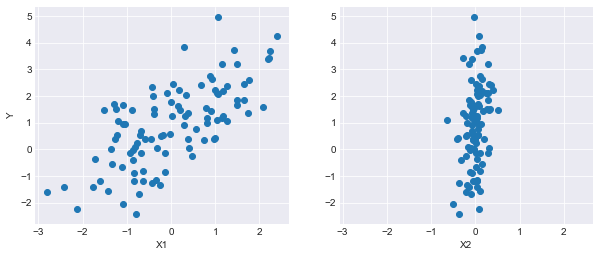

In [3]:
%matplotlib inline
fig, axes = plt.subplots(1,2, sharex = True, figsize = (10,4))
axes[0].scatter(X1,Y)
axes[1].scatter(X2,Y)
axes[0].set_xlabel("X1"); axes[0].set_ylabel("Y"); axes[1].set_xlabel("X2")

Here we generated data set from predetermined parameters, alpha, betas and sigma.

In [4]:
import pymc3 as pm


In [5]:
print('Running on pyMC3 v{}'.format(pm.__version__))

Running on pyMC3 v3.7


In [10]:
basic_model = pm.Model()

with basic_model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta= pm.Normal('beta',mu=0,sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    
    # Expected value of outcome
    mu = alpha +beta[0]*X1 +beta[1]*X2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal(name = 'Y_obs', mu = mu, sigma = sigma, observed = Y)

In [11]:
map_estimate=pm.find_MAP(model = basic_model)

/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 483.49it/s]  


In [12]:
map_estimate


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

So they are my posterior modes.